In [36]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

def perfect_scale(N, λ):
  return (λ * N) / 1


def amdahl_scale(N, λ, σ):
  return (λ * N) / (1 + (σ * (N - 1)))


def usl_scale(N, λ, σ, κ):
  return (λ * N) / (1 + (σ * (N - 1)) + (κ * N * (N - 1)))


def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "Nmax={:.3f}, X(N)={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)


N = np.linspace(0, 20)

# Scaling Laws and Modeling

[Gartner's definition of Scalability](gartner-scalability-definition):

> Scalability is the measure of a system’s ability to increase or decrease in performance and cost in response to changes in application and system processing demands.

While that is a sufficient definition for understanding what scalability is, it doesn't offer any guidance on how you go about increasing or decreasing performance and cost based on processing demands.

Systems that make up Computers, Computers, and systems of Computers are governed by the laws of queueing theory, and queueing theory applies to all queues. Service time is service time whether you're measuring it in a program or measuring it a retail checkout, and queue theory applies to each.

Dr. Neil J. Gunther defines scalability as a _mathematical function_, a relationship between dependent and independent variables.

To understand a scalability model you must choose the correct variables to describe how the system operates. Since scalability is driven by the _**work**_ done by the system, a few of those variables could include:

* Units of work (requests)
* The rate of requests over time (arrival rate)
* The number of units of work in a system at a time (concurrency)
* The number of customers, users, or driver processes sending requests (actors)

Each of these play a role in the scalability function, depending on the system. For instance, it's common to configure the number of nodes for a system under test (SUT) while holding constant the number of requests each node handles, or if you're evaluating the JVM in a single pod, you would vary the number of CPUs and maintain the same workload for each configuration. In the first case the amount of work is defined by the number of requests applied to each node and the output is the completion rate, and in the second case, the independent variable is the number of CPUs and the dependent variable is the completion rate.

Fundamentally, scalability is a _function of size_ or _load_, which are both measures of _concurrency_. The dependent variable will be the rate at which the system can complete work, or _throughput_. In perfect scalability the system should complete more work as the size of the system or the load on the system grows, so it should be an increasing function.

**Scalability is a mathematical function, with size or load on the $X$ axis, and throughput on the $Y$ axis.**

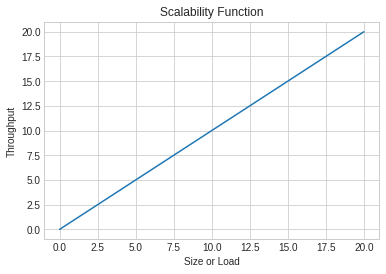

In [37]:
fig1 = plt.figure()
ax1 = plt.axes()
x1 = np.linspace(0, 20)
ax1.set(xlabel='Size or Load', ylabel='Throughput', title='Scalability Function')
_ = ax1.plot(x1, x1) # hides the text output of plot

**Concurrency**
The symbol $N$ is used initially to describe a node in a system (e.g. the thread in a JVM, the CPU in a pod, a pod in a cluster, etc.), and later when discussing throughput and latency, $N$ is used to describe the mean number of requests in a system. Many people new to scalability are confused by this... how is it that the number of workers and the requests resident in the system are equivalent when evaluating throughput and latency?

_**Concurrency is a measure of the number of units of work being worked on simultaneously, which is the size of a system (workers), or the load on a system (how many requests resident in the system at a time). Therefore, $N$ represents that concurrency in both cases.**_

## Perfect Linear Scaling

An ideal system of size $N=1$ achieves some amount $\lambda$ of throughput $X$, in completed requests per second.

\begin{equation}
X(N)=\frac{\lambda N}1
\end{equation}

Where $\lambda$ is the "performance" coefficient and defines the slope of the line of linear scalability, where there is no contention or crosstalk penalty. In this ideal system, $\lambda=2$ equals double the throughput, and so on.

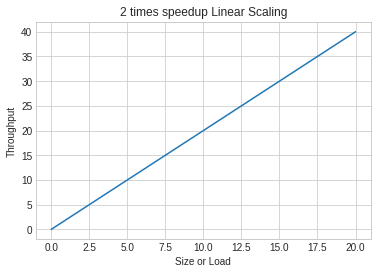

In [38]:
fig2 = plt.figure()
ax2 = plt.axes()
ax2.set(xlabel='Size or Load', ylabel='Throughput', title='2 times speedup Linear Scaling')
l2 = 2
_ = ax2.plot(N, perfect_scale(N, l2))

## Serialization penalty and Amdahl's Law

Amdahl's Law states that the maximum speedup possible by parallelization is the reciprocal of the serialized portion of the work.

\begin{equation}
X(N)=\frac{\lambda N}{1+\sigma(N-1)}
\end{equation}

Where $\sigma$ is the "contention" or "serialization" coefficient. A system with serialization will **asymptotically** approach a speedup limit.

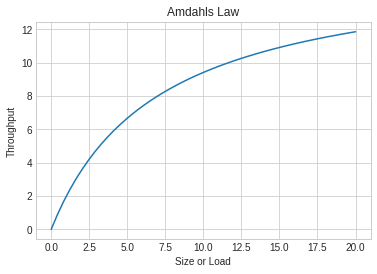

In [39]:
fig3 = plt.figure()
ax3 = plt.axes()
ax3.set(xlabel='Size or Load', ylabel='Throughput', title='Amdahl''s Law')
l3 = 2
s3 = .125
_ = ax3.plot(N, amdahl_scale(N, l3, s3))


## Crosstalk penalty and the Universal Scalability Law

The Universal Scalabality Law states that a crosstalk (aka consistency or coherency) penalty occurs when pairwise communication between workers is required for synchronization. Crosstalk potentially happens between each pair of workers, and the number of edges of a fully connected graph is $n(n-1)$.

\begin{equation}
X(N)=\frac{\lambda N}{1+\sigma(N-1)+\kappa N(N-1)}
\end{equation}

Where $\kappa$ is the "crosstalk" coefficient and because it is quadratic, eventually it grows faster than the linear speedup, causing retrograde scalability.

For all $\kappa>0$:
\begin{equation}
N\max=\Biggl\lfloor\sqrt{\frac{1-\sigma}{\kappa}}\Biggr\rfloor
\end{equation}

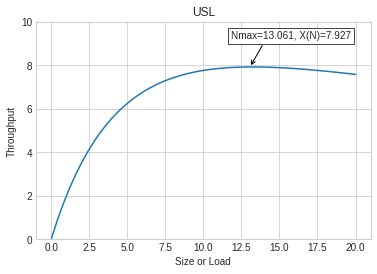

In [40]:
fig4 = plt.figure()
ax4 = plt.axes()
ax4.set(xlabel='Size or Load', ylabel='Throughput', ylim=(0,10), title='USL')
l4 = 2
s4 = .125
k4 = .005
ax4.plot(N, usl_scale(N, l4, s4, k4))
annot_max(N, usl_scale(N, l4, s4, k4))


### Response Time and Little's Law

System performance is measured in throughput and request performance is measured in latency. Response time, latency, and residence time are synonomous. Most benchmarks measure overall system throughput, and users care about the response times of individual requests.

Little's Law states that the mean number of requests resident in a system $(N)$ is equal to the throughput $(X)$ times the mean response time $(R)$.

This relationship is valid for a stable system in which all requests complete.

\begin{equation}
N=XR
\end{equation}

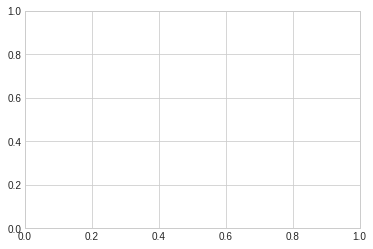

In [41]:
fig5 = plt.figure()
ax5 = plt.axes()




Response time of a linearily scalable system:

\begin{equation}
R(X)=\frac{1}{\lambda}
\end{equation}

USL for response time as a function of concurrency.

\begin{equation}
R(N)=\frac{1+\sigma(N-1)+\kappa N(N-1)}{\lambda}
\end{equation}

With a positive $\sigma$ coefficient:

\begin{equation}
R(X)=\frac{\sigma-1}{\sigma X-\lambda}
\end{equation}

[gartner-scalability-definition]: https://www.gartner.com/en/information-technology/glossary/scalability